0
1
2
3



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 512)     14336     
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 512)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 71, 71, 512)       2048      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 256)       0         
 g2D)                                                            
                                             

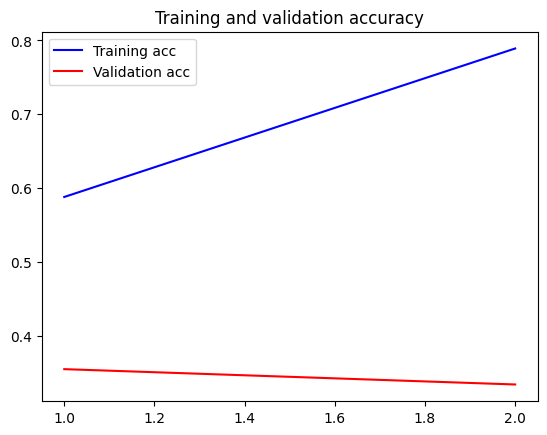

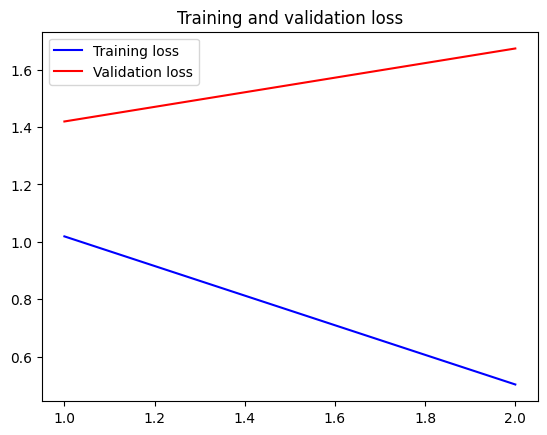

19/19 [==============================] - 77s 4s/step - loss: 1.6739 - accuracy: 0.3339
Test accuracy: 0.3339100480079651
INFO:tensorflow:Assets written to: drowiness.model\assets


INFO:tensorflow:Assets written to: drowiness.model\assets


In [3]:
import numpy as np 
import pandas as pd 
import os
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Reshape, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define function to extract face images with labels (yawn or no yawn)
def face_for_yawn(direc="C:/Users/Haseeb Raza/Desktop/driver drowniess/train", face_cas_path="C:/Users/Haseeb Raza/Desktop/driver drowniess/train/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no

# Define function to get data (closed and open eyes)
def get_data(dir_path="C:/Users/Haseeb Raza/Desktop/driver drowniess/train", eye_cas="C:/Users/Haseeb Raza/Desktop/driver drowniess/train/haarcascade_frontalface_default.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

# Append face images data with eye images data
def append_data():
    total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    features, labels = zip(*yaw_no)
    return np.vstack(features), np.array(labels)

# Call the append_data function to get the combined dataset
X, y = append_data()

# Reshape X to match the input shape of the CNN
X = X.reshape(-1, 145, 145, 3)

# Convert labels using LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
y = np.array(y)

# Split the data into training and testing sets
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# Create data generators for training and testing
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(X_train, y_train, shuffle=False, batch_size=32)
test_generator = test_generator.flow(X_test, y_test, shuffle=False, batch_size=32)

# Build the model
model = Sequential()

model.add(Conv2D(512, (3, 3), activation="relu", input_shape=(145, 145, 3)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))

# reshape output of CNN to be compatible with LSTM layer
model.add(Reshape((8, 8)))
# changed the reshape size to match LSTM input

model.add(LSTM(64, dropout=0.5))

model.add(Dense(4, activation="softmax"))

# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Print model summary
model.summary()

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with reduced epochs and early stopping
history = model.fit(train_generator, epochs=2, steps_per_epoch=len(train_generator),
                    validation_data=test_generator, validation_steps=len(test_generator),
                    callbacks=[early_stopping])

# Plot accuracy and loss curves for training and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

# Save the model
model.save("drowiness.model")


In [4]:
import os
os.getcwd()  # This will give you the current working directory


'c:\\Users\\Haseeb Raza\\Desktop\\driver drowniess'

In [1]:
pip install keras-tcn


   ---------------------------------------- 0.0/719.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/719.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/719.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/719.8 kB ? eta -:--:--
   - -------------------------------------- 30.7/719.8 kB ? eta -:--:--
   - -------------------------------------- 30.7/719.8 kB ? eta -:--:--
   - -------------------------------------- 30.7/719.8 kB ? eta -:--:--
   --- ----------------------------------- 61.4/719.8 kB 328.2 kB/s eta 0:00:03
   ----- -------------------------------- 112.6/719.8 kB 504.4 kB/s eta 0:00:02
   ------- ------------------------------ 133.1/719.8 kB 463.7 kB/s eta 0:00:02
   -------- ----------------------------- 163.8/719.8 kB 579.6 kB/s eta 0:00:01
   ---------- --------------------------- 204.8/719.8 kB 541.9 kB/s eta 0:00:01
   --------------- ---------------------- 286.7/719.8 kB 681.0 kB/s eta 0:00:01
   --------------- -


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


0
1
2
3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 143, 143, 512)     14336     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 71, 71, 512)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_10 (Ba  (None, 71, 71, 512)       2048      
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 69, 69, 256)       1179904   
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 34, 34, 256)       0         
 ng2D)                                                           
                                             

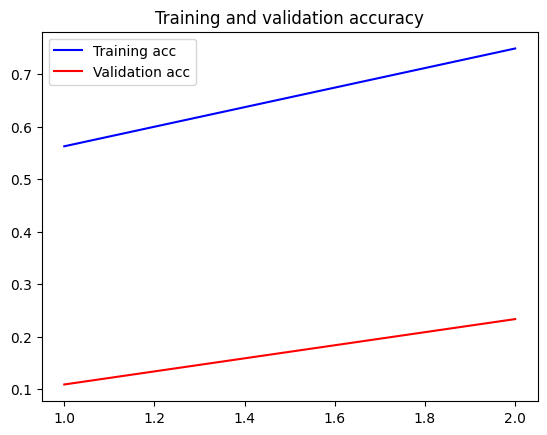

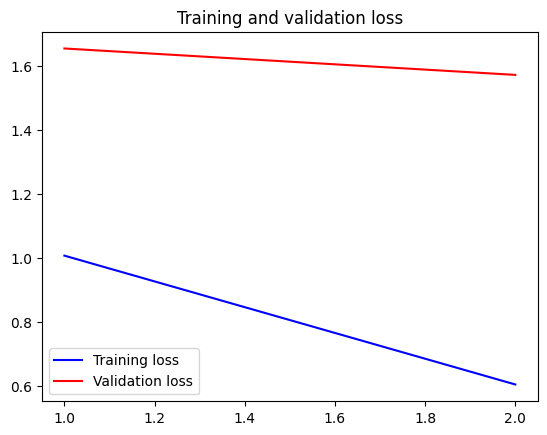

19/19 [==============================] - 82s 4s/step - loss: 1.5708 - accuracy: 0.2336
Test accuracy: 0.23356401920318604
INFO:tensorflow:Assets written to: drowiness_Tcn.model\assets


INFO:tensorflow:Assets written to: drowiness_Tcn.model\assets


In [6]:
import numpy as np 
import pandas as pd 
import os
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Reshape, BatchNormalization, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tcn import TCN  # Importing TCN layer from keras-tcn package

# Define function to extract face images with labels (yawn or no yawn)
def face_for_yawn(direc="C:/Users/Haseeb Raza/Desktop/driver drowniess/train", face_cas_path="C:/Users/Haseeb Raza/Desktop/driver drowniess/train/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no

# Define function to get data (closed and open eyes)
def get_data(dir_path="C:/Users/Haseeb Raza/Desktop/driver drowniess/train", eye_cas="C:/Users/Haseeb Raza/Desktop/driver drowniess/train/haarcascade_frontalface_default.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

# Append face images data with eye images data
def append_data():
    total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    features, labels = zip(*yaw_no)
    return np.vstack(features), np.array(labels)

# Call the append_data function to get the combined dataset
X, y = append_data()

# Reshape X to match the input shape of the CNN
X = X.reshape(-1, 145, 145, 3)

# Convert labels using LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
y = np.array(y)

# Split the data into training and testing sets
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# Create data generators for training and testing
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(X_train, y_train, shuffle=False, batch_size=32)
test_generator = test_generator.flow(X_test, y_test, shuffle=False, batch_size=32)

# Build the model
model = Sequential()

model.add(Conv2D(512, (3, 3), activation="relu", input_shape=(145, 145, 3)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))

# reshape output of CNN to be compatible with LSTM layer
model.add(Reshape((8, 8)))
# changed the reshape size to match LSTM input

model.add(LSTM(64, dropout=0.5, return_sequences=True))

# Adding TimeDistributed layer to ensure the input shape is correct for TCN
model.add(TimeDistributed(Dense(64)))

# Adding TCN layer
model.add(TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8, 16, 32]))

model.add(Dense(4, activation="softmax"))

# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Print model summary
model.summary()

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with reduced epochs and early stopping
history = model.fit(train_generator, epochs=2, steps_per_epoch=len(train_generator),
                    validation_data=test_generator, validation_steps=len(test_generator),
                    callbacks=[early_stopping])

# Plot accuracy and loss curves for training and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

# Save the model
model.save("drowiness_Tcn.model")
